# Maizeを利用してSBVSの前処理とドッキングシミュレーションを実行する



## 生成モデルから発生させた構造を確認する

SBVSを実施する前に構造を確認します。コードの詳細は割愛します。

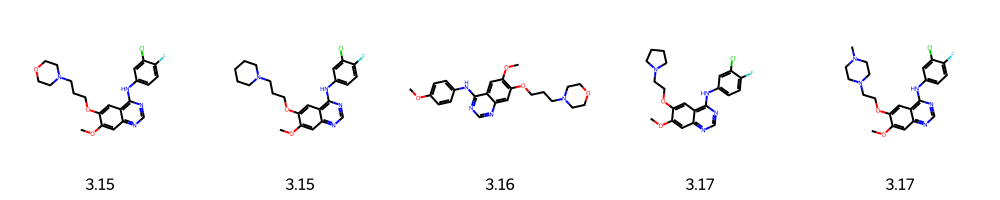

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd

df = pd.read_csv('./TL_sampling.csv')
smiles_lst = [row['SMILES'] for idx, row in df.iterrows()]
# used first
smiles_lst = [s for s in smiles_lst][1:6]

mols = [Chem.MolFromSmiles(smi) for smi in smiles_lst]
Draw.MolsToGridImage(mols[:6], legends=[str(nll) for nll in df.NLL][:6], molsPerRow=5)

## Maizeのワークフローを構築する

XXで設定したtomlファイルからGypsumとAutoDock Vina用のノードを追加します。

In [2]:
from pathlib import Path
from maize.core.workflow import Workflow
from maize.steps.io import LoadData, LogResult, Return
import os, sys

from maize.steps.mai.docking.adv import Vina
from maize.steps.mai.molecule import Gypsum
from maize.utilities.chem import IsomerCollection

In [3]:
flow = Workflow(name='dock', level='info', cleanup_temp=True)
load = flow.add(LoadData[list[str]])
#void = flow.add(Void)
# 3D conf gen and protonate
embe = flow.add(Gypsum)
# run vina docking
dock = flow.add(Vina)
# receive docke results
retu = flow.add(Return[list[IsomerCollection]])

### AutoDock Vinaの設定

ドッキングシミュレーションの設定をします。ハンズオンでは説明しませんので詳細はAutoDock Vinaのドキュメントを参照してください。

In [4]:
load.data.set(smiles_lst)
embe.n_variants.set(2)
embe.timeout.set(10)
# RIP3K <https://www.rcsb.org/structure/7MON>
dock.receptor.set(Path('/home/iwatobipen/dev/CBI/cheminfo_tutorial_20241028/data/2ito_fix_remh.pdbqt'))
dock.search_center.set((-56.643,  -6.844, -23.487))
dock.search_range.set((20.00, 20.00, 20.00))
# default vaule 8 seems too small ...
dock.exhaustiveness.set(16)

最後にノードを接続します。

In [5]:
flow.connect(load.out, embe.inp)
flow.connect(embe.out, dock.inp)
flow.connect(dock.out,retu.inp)
flow.check()

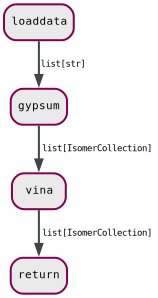

In [6]:
flow.visualize() # ワークフローを視覚化

In [7]:
flow.execute() #実行

2024-10-15 21:51:26,391 |     INFO |             dock | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-15 21:51:26,392 |     INFO |             dock | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-15 21:5

2024-10-15 21:51:29,949 |     INFO |             dock | Node 'gypsum' finished (2/4)


2024-10-15 21:54:17,895 |     INFO |             vina | Job completed (1/10)


2024-10-15 21:54:23,325 |     INFO |             vina | Job completed (2/10)


2024-10-15 21:54:43,305 |     INFO |             vina | Job completed (3/10)


2024-10-15 21:54:53,736 |     INFO |             vina | Job completed (4/10)


2024-10-15 21:55:00,751 |     INFO |             vina | Job completed (5/10)


2024-10-15 21:55:03,744 |     INFO |             vina | Job completed (6/10)


2024-10-15 21:55:12,698 |     INFO |             vina | Job completed (7/10)


2024-10-15 21:55:26,179 |     INFO |             vina | Job completed (8/10)


2024-10-15 21:55:45,206 |     INFO |             vina | Job completed (9/10)


2024-10-15 21:55:50,118 |     INFO |             vina | Job completed (10/10)
2024-10-15 21:55:50,188 |     INFO |             dock | Workflow status
                                   |         loaddata | COMPLETED
                                   |             vina | RUNNING
                                   |           return | WAITING_FOR_INPUT
                                   |           gypsum | COMPLETED
2024-10-15 21:55:50,187 |     INFO |             vina | Parsing isomer 0: 'XGALLCVXEZPNRQ-LELJVTLKNA-N'
2024-10-15 21:55:50,191 |     INFO |             vina | Parsing isomer 1: 'IFIRBZOPPUFQRQ-GJWLQAPINA-P'
2024-10-15 21:55:50,193 |     INFO |             vina | Parsing isomer 2: 'IFIRBZOPPUFQRQ-XVHJMYKLNA-O'
2024-10-15 21:55:50,197 |     INFO |             vina | Parsing isomer 3: 'NOSWWYFJKOPCTB-LDJVHMMSNA-O'
2024-10-15 21:55:50,200 |     INFO |             vina | Parsing isomer 4: 'BLFAAYGECSULMU-MCZQYZLCNA-O'
2024-10-15 21:55:50,203 |     INFO |             vina | Pars

# 此処から先の説明はまだ

In [ ]:
!mkdir dock_res

In [ ]:
res=retu.get()
import numpy as np
from pathlib import Path
for midx, ms in enumerate(res):
    for cidx, m in enumerate(ms.molecules):
        m.to_sdf(Path(f'./dock_res/ok_{midx}_{cidx}.sdf'))

In [ ]:
res[0].molecules[1]